<a href="https://colab.research.google.com/github/pszachew/Delivery-Prediction/blob/master/DataPreprocessing_3classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [19]:
def get_preprocess():
  deliveries = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/deliveries.jsonl', lines=True)
  sessions = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/sessions.jsonl', lines=True)
  products = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/products.jsonl', lines=True)
  users = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/users.jsonl', lines=True)
  ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']
  deliveries['delivery_timestamp'] = deliveries['delivery_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['delivery_weekday'] = deliveries['delivery_timestamp'].apply(lambda x: ls[x.weekday()])
  deliveries['delivery_day'] = deliveries['delivery_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['purchase_timestamp'] = deliveries['purchase_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['purchase_day'] = deliveries['purchase_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['diff_days'] = (deliveries['delivery_day'] - deliveries['purchase_day']).apply(lambda x: x.days)
  tmp = deliveries['diff_days']
  deliveries['purchase_morning'] = deliveries['purchase_timestamp'].apply(lambda x: 1 if x.hour<=14 else 0)
  all_info = deliveries.merge(sessions.merge(products, on='product_id', how='left'), on='purchase_id', how='left')
  all_info = all_info.merge(users, on='user_id', how='left')
  dec_var = ["delivery_company", 'diff_days', 'purchase_morning', 'city', 'delivery_weekday']
  all_info = all_info.drop(all_info.index[all_info['diff_days'].isin([0,5])], axis=0)
  all_info = all_info[dec_var]
  city_dum = pd.get_dummies(all_info['city'], drop_first=True)
  weekday_dum = pd.get_dummies(all_info['delivery_weekday'], drop_first=True)
  delivery_company_dum = pd.get_dummies(all_info['delivery_company'], drop_first=True)
  delivery_company_dum = delivery_company_dum.rename(columns={360:'delivery_360', 254:'delivery_254', 516:'delivery_516', 620:'delivery_620'})
  all_info.drop('delivery_company', axis=1, inplace=True)
  all_info.drop('city', axis=1, inplace=True)
  all_info.drop('delivery_weekday', axis=1, inplace=True)
  final = pd.concat([all_info, city_dum, delivery_company_dum, weekday_dum], axis=1)
  return final.drop('diff_days', axis=1), final['diff_days'], tmp

## **Przewidywanie 4 klas. Dni ze zbioru {1,2,3,4}**

In [20]:
X, y, tmp = get_preprocess()
#y = y.apply(lambda x: 3 if x>3 else x)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


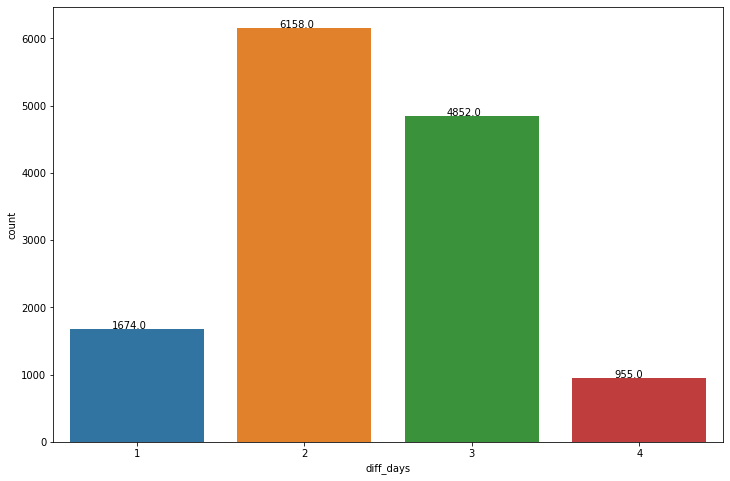

In [21]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [ ]:
X

,purchase_morning,Kraków,Poznań,Radom,Szczecin,Warszawa,Wrocław,delivery_360,delivery_516,delivery_620,monday,saturday,thursday,tuesday,wednesday
0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13755,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0
13756,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
13757,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
13758,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0


## **Logistic Regression**

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [24]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pre = model.predict(X_test)
print(accuracy_score(y_test, y_pre))
print(classification_report(y_test, y_pre))

0.6358586980670962
              precision    recall  f1-score   support

           1       0.69      0.55      0.61       556
           2       0.66      0.71      0.68      2028
           3       0.60      0.67      0.63      1611
           4       0.43      0.14      0.21       306

    accuracy                           0.64      4501
   macro avg       0.60      0.52      0.53      4501
weighted avg       0.63      0.64      0.62      4501



In [25]:
cm = confusion_matrix(y_test, y_pre)

In [26]:
print(cm)

[[ 305  244    7    0]
 [ 129 1433  456   10]
 [   5  479 1082   45]
 [   0   12  252   42]]


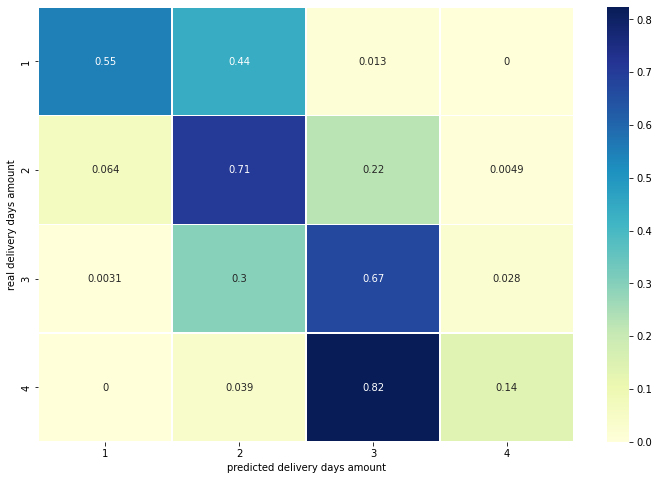

In [33]:
cm2 = confusion_matrix(y_test, y_pre, normalize='true')
cm2 = pd.DataFrame(cm2, index=[1,2,3,4], columns=[1,2,3,4])
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

Jak widać większość dostaw, które zostały dostarczone po 4 dniach zostały zaklasyfikowane przez system jako te dostarczone po 3 dniach. W związku z taką sytuacją można połączyć klasę 4 i 3. 

## **Przewidywanie 3 klas - dni ze zbioru {1,2,3}**

## **Pierwszy model Regresja Logistyczna**

In [35]:
X, y, tmp = get_preprocess()
y = y.apply(lambda x: 3 if x>3 else x)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pre = model.predict(X_test)
print(accuracy_score(y_test, y_pre))
print(classification_report(y_test, y_pre))

0.7018440346589647
              precision    recall  f1-score   support

           1       0.69      0.55      0.61       556
           2       0.66      0.71      0.68      2028
           3       0.75      0.74      0.75      1917

    accuracy                           0.70      4501
   macro avg       0.70      0.67      0.68      4501
weighted avg       0.70      0.70      0.70      4501



In [38]:
cm = confusion_matrix(y_test, y_pre)

In [39]:
print(cm)

[[ 305  244    7]
 [ 129 1433  466]
 [   5  491 1421]]


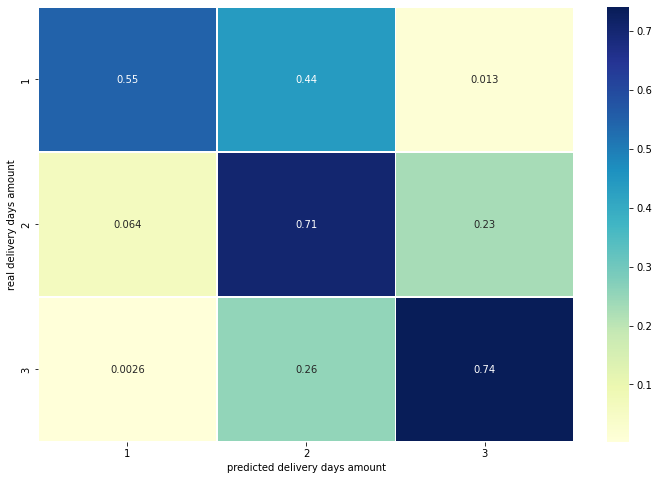

In [41]:
cm2 = confusion_matrix(y_test, y_pre, normalize='true')
cm2 = pd.DataFrame(cm2, index=[1,2,3], columns=[1,2,3])
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

Na powyższym diagramie widać, że model jest w stanie przewidywać dzień dostawy z dokładnością oscylującą w okolicach 70% dla dwóch i trzech dni. Dla dostaw trwających 1 dzień ta dokładność była mniejsza i wynosiła jedynie 55%.

Warto tutaj zwrócić uwagę, że różnica pomiędzy predykcją, a rzeczywistym czasem dostawy w praktyce nie przekracza jednego dnia.

## **MLPClassifier**

In [34]:
from sklearn.neural_network import MLPClassifier

In [45]:
X, y, tmp = get_preprocess()
y = y.apply(lambda x: 3 if x>3 else x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [46]:
MLPclass = MLPClassifier(hidden_layer_sizes=(16,16), random_state=8, activation='relu')
MLPclass.fit(X_train, y_train)
y_pred = MLPclass.predict(X_test)

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.76      0.54      0.63       556
           2       0.67      0.74      0.70      2028
           3       0.76      0.75      0.76      1917

    accuracy                           0.72      4501
   macro avg       0.73      0.68      0.70      4501
weighted avg       0.72      0.72      0.72      4501



In [48]:
confusion_matrix(y_test, y_pred)

array([[ 300,  246,   10],
       [  95, 1491,  442],
       [   1,  474, 1442]])

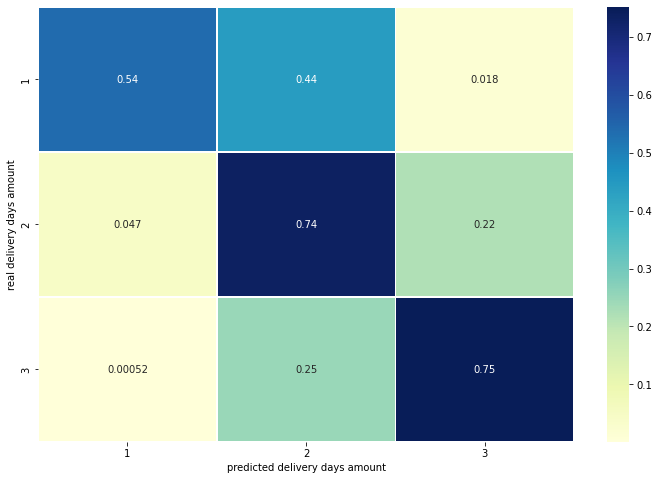

In [49]:
cm2 = confusion_matrix(y_test, y_pred, normalize='true')
cm2 = pd.DataFrame(cm2, index=[1,2,3], columns=[1,2,3])
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

Na powyższym diagramie przedstawiającym wyniki dla modelu MLP widać, że model jest w stanie przewidywać dzień dostawy z dokładnością oscylującą w okolicach 75% dla dwóch i trzech dni. Dla dostaw trwających 1 dzień ta dokładność była mniejsza i wynosiła jedynie 55%.

Różnica pomiędzy predykcją, a rzeczywistym czasem dostawy w praktyce nie przekracza jednego dnia.

Wyniki otrzymane przez MLP są lepsze od wyników regresji tylko dla predykcji dostaw trwających 2 dni. W pozostałych wypadkach otrzymane rezultaty są takie same.